### Github link: https://github.com/R0ner/comsosci-assignments
### All group members contributed equally to all parts of the assignment

# Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx
import datetime as dt
import shifterator as sh
import nltk
import re
import json

from wordcloud import WordCloud
from networkx.readwrite import json_graph
from collections.abc import Iterable
from collections import Counter
from scipy import stats

## Part 1: TF-IDF

### Preliminaries

In [2]:
submissions = pd.read_csv('wallstreet_subs.csv')
submissions['date'] = pd.to_datetime(submissions['created_utc'], unit='s').dt.date
submissions['date'] = pd.to_datetime(submissions['date'])
submissions.head()

,created_utc,title,selftext,score,date
0,1586173811,What is the Fed actually buying?,"Okay, I may actually just be retarded. On my d...",1,2020-04-06
1,1586173320,I didn’t learn about puts because I was lazy,"Beginning of the this virus shit, everyone was...",1,2020-04-06
2,1586173268,HOT TAKE,Literally everyone has free time on their hand...,1,2020-04-06
3,1586172639,Fuck you Gordon,"Gordon I believed in you, I can't even begin t...",1,2020-04-06
4,1586171822,Can’t find a picture,Someone uploaded a ohoto of the stock market h...,1,2020-04-06


In [3]:
submissions['text'] = submissions['title'] + ' ' + submissions['selftext']
submissions.head()

,created_utc,title,selftext,score,date,text
0,1586173811,What is the Fed actually buying?,"Okay, I may actually just be retarded. On my d...",1,2020-04-06,"What is the Fed actually buying? Okay, I may a..."
1,1586173320,I didn’t learn about puts because I was lazy,"Beginning of the this virus shit, everyone was...",1,2020-04-06,I didn’t learn about puts because I was lazy B...
2,1586173268,HOT TAKE,Literally everyone has free time on their hand...,1,2020-04-06,HOT TAKE Literally everyone has free time on t...
3,1586172639,Fuck you Gordon,"Gordon I believed in you, I can't even begin t...",1,2020-04-06,"Fuck you Gordon Gordon I believed in you, I ca..."
4,1586171822,Can’t find a picture,Someone uploaded a ohoto of the stock market h...,1,2020-04-06,Can’t find a picture Someone uploaded a ohoto ...


In [4]:
regex = '^\$\w+'

In [5]:
tickers = submissions['text'].str.findall(regex).sum()

tickers = [ticker.upper() for ticker in tickers if not bool(re.search(r'\d', ticker))]

unique_tickers, counts = np.unique(tickers, return_counts=True)
sorted_indices = np.argsort(counts)[::-1]
top_15 = unique_tickers[sorted_indices][:15]
top_15

array(['$TSLA', '$SPCE', '$SPY', '$PLTR', '$NIO', '$MSFT', '$ZM', '$AAPL',
       '$BABA', '$PTON', '$GME', '$DIS', '$BA', '$RKT', '$NKLA'],
      dtype='<U27')

### 1.
Tokenize the __text__ of each submission. Create a column __tokens__ in your dataframe containing the tokens.

In [6]:
stop_words = set(nltk.corpus.stopwords.words('english'))
stop_words = [re.sub('[^a-z_-]', '', stop_word) for stop_word in stop_words]

def tokenize(row):
    text = row['text'].lower()
    text = re.sub('[^a-z]', ' ', text)
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if not word in stop_words and 'http' not in word and len(word) > 1]
    tokens = list(set(tokens))
    return tokens


In [7]:
submissions['tokens'] = submissions.apply(tokenize, axis=1)
submissions.head()

,created_utc,title,selftext,score,date,text,tokens
0,1586173811,What is the Fed actually buying?,"Okay, I may actually just be retarded. On my d...",1,2020-04-06,"What is the Fed actually buying? Okay, I may a...","[everyone, corporate, okay, would, actually, s..."
1,1586173320,I didn’t learn about puts because I was lazy,"Beginning of the this virus shit, everyone was...",1,2020-04-06,I didn’t learn about puts because I was lazy B...,"[got, everyone, puts, holy, lazy, whats, coupl..."
2,1586173268,HOT TAKE,Literally everyone has free time on their hand...,1,2020-04-06,HOT TAKE Literally everyone has free time on t...,"[take, us, everyone, bored, means, stonks, pag..."
3,1586172639,Fuck you Gordon,"Gordon I believed in you, I can't even begin t...",1,2020-04-06,"Fuck you Gordon Gordon I believed in you, I ca...","[market, take, us, begin, ass, even, took, dil..."
4,1586171822,Can’t find a picture,Someone uploaded a ohoto of the stock market h...,1,2020-04-06,Can’t find a picture Someone uploaded a ohoto ...,"[someone, uploaded, market, another, stock, hu..."


### 2. 
Find submissions discussing at least one of the top 15 stocks you identified above

In [8]:
# intersection function
top_15_set = set([re.sub('[^a-z]', '', stock.lower()) for stock in top_15])
isect = lambda row: list(top_15_set.intersection(set(row['tokens'])))

In [9]:
submissions['stock'] = submissions.apply(isect, axis=1)
submissions.head()

,created_utc,title,selftext,score,date,text,tokens,stock
0,1586173811,What is the Fed actually buying?,"Okay, I may actually just be retarded. On my d...",1,2020-04-06,"What is the Fed actually buying? Okay, I may a...","[everyone, corporate, okay, would, actually, s...",[]
1,1586173320,I didn’t learn about puts because I was lazy,"Beginning of the this virus shit, everyone was...",1,2020-04-06,I didn’t learn about puts because I was lazy B...,"[got, everyone, puts, holy, lazy, whats, coupl...",[]
2,1586173268,HOT TAKE,Literally everyone has free time on their hand...,1,2020-04-06,HOT TAKE Literally everyone has free time on t...,"[take, us, everyone, bored, means, stonks, pag...",[]
3,1586172639,Fuck you Gordon,"Gordon I believed in you, I can't even begin t...",1,2020-04-06,"Fuck you Gordon Gordon I believed in you, I ca...","[market, take, us, begin, ass, even, took, dil...",[]
4,1586171822,Can’t find a picture,Someone uploaded a ohoto of the stock market h...,1,2020-04-06,Can’t find a picture Someone uploaded a ohoto ...,"[someone, uploaded, market, another, stock, hu...",[]


In [10]:
submissions = submissions.explode('stock')
submissions.head()

,created_utc,title,selftext,score,date,text,tokens,stock
0,1586173811,What is the Fed actually buying?,"Okay, I may actually just be retarded. On my d...",1,2020-04-06,"What is the Fed actually buying? Okay, I may a...","[everyone, corporate, okay, would, actually, s...",NaN
1,1586173320,I didn’t learn about puts because I was lazy,"Beginning of the this virus shit, everyone was...",1,2020-04-06,I didn’t learn about puts because I was lazy B...,"[got, everyone, puts, holy, lazy, whats, coupl...",NaN
2,1586173268,HOT TAKE,Literally everyone has free time on their hand...,1,2020-04-06,HOT TAKE Literally everyone has free time on t...,"[take, us, everyone, bored, means, stonks, pag...",NaN
3,1586172639,Fuck you Gordon,"Gordon I believed in you, I can't even begin t...",1,2020-04-06,"Fuck you Gordon Gordon I believed in you, I ca...","[market, take, us, begin, ass, even, took, dil...",NaN
4,1586171822,Can’t find a picture,Someone uploaded a ohoto of the stock market h...,1,2020-04-06,Can’t find a picture Someone uploaded a ohoto ...,"[someone, uploaded, market, another, stock, hu...",NaN


In [11]:
submissions.loc[submissions['stock'].isnull(), 'stock'] = 'other'
submissions.head()

,created_utc,title,selftext,score,date,text,tokens,stock
0,1586173811,What is the Fed actually buying?,"Okay, I may actually just be retarded. On my d...",1,2020-04-06,"What is the Fed actually buying? Okay, I may a...","[everyone, corporate, okay, would, actually, s...",other
1,1586173320,I didn’t learn about puts because I was lazy,"Beginning of the this virus shit, everyone was...",1,2020-04-06,I didn’t learn about puts because I was lazy B...,"[got, everyone, puts, holy, lazy, whats, coupl...",other
2,1586173268,HOT TAKE,Literally everyone has free time on their hand...,1,2020-04-06,HOT TAKE Literally everyone has free time on t...,"[take, us, everyone, bored, means, stonks, pag...",other
3,1586172639,Fuck you Gordon,"Gordon I believed in you, I can't even begin t...",1,2020-04-06,"Fuck you Gordon Gordon I believed in you, I ca...","[market, take, us, begin, ass, even, took, dil...",other
4,1586171822,Can’t find a picture,Someone uploaded a ohoto of the stock market h...,1,2020-04-06,Can’t find a picture Someone uploaded a ohoto ...,"[someone, uploaded, market, another, stock, hu...",other


### 3. 
Now, we want to find out which words are important for each *stock*, so we're going to create several ***large documents, one for each stock***. Each document includes all the tokens related to the same stock. We will also have a document including discussions that do not relate to the top 15 stocks.

In [12]:
documents = {stock: list(np.concatenate(tuple(submissions.loc[submissions['stock'] == stock, 'tokens']))) for stock in top_15_set}

### 4. 
Now, we're ready to calculate the TF for each word. Find the top 5 terms within __5 stocks of your choice__. 
* Describe similarities and differences between the stocks.
* Why aren't the TFs not necessarily a good description of the stocks?
* Next, we calculate IDF for every word. 
* What base logarithm did you use? Is that important?

In [13]:
stonks = ['tsla', 'gme', 'aapl', 'zm', 'dis']

In [14]:
def term_frequency(document: list) -> tuple[np.array, np.array]:
    """This function calculates the term frequency of a document.
    The term frequency is normalized by the total number of words in the document.
    Returns a tuple of arrays. The first array is the terms and the second array is
    the term frequency in the same order.
    
    Arguments:
        document (np.array): array of tokens.
    """
    fdist = nltk.FreqDist(document)
    n_words = fdist.N()
    terms = np.array(list(fdist.keys()))
    tf = np.array(list(fdist.values())) / n_words
    
    return tf, terms


def inverse_document_frequency(documents: dict[list], corpus=None) -> dict[float]:
    """This function computes the inverse document frequency (idf) given
    a list of documents and a set of terms.
    """
    if corpus is None:
        corpus = documents.keys()
    
    n_documents = len(corpus)
    terms, counts = np.unique(
        np.concatenate([list(set(documents[d])) for d in corpus]),
        return_counts=True
    )
    
    idf = np.log(n_documents / (counts))
    idf_lookup = {term: w for term, w in zip(terms, idf)}
    
    return idf_lookup

def tf_idf(document: list, idf_lookup: dict[float]) -> tuple[np.array, np.array]:
    """Computes the tf-idf of a document, given a document and a lookup table for idf."""
    tf, terms = term_frequency(document)
    idf = np.array([idf_lookup[term] for term in terms])
    
    return tf * idf, terms

In [15]:
# Top 5 words, TF
print('Top 5 terms sorted by term frequency (TF):')

for stock in stonks:
    tf, terms = term_frequency(documents[stock])
    sorted_indices = np.argsort(tf)[::-1]
    stock_top_5 = terms[sorted_indices[:5]]
    print(f'${stock.upper()}:')
    print(stock_top_5)

# Not very informative...

Top 5 terms sorted by term frequency (TF):
$TSLA:
['tsla' 'like' 'calls' 'buy' 'stock']
$GME:
['gme' 'shares' 'short' 'buy' 'going']
$AAPL:
['aapl' 'calls' 'like' 'market' 'buy']
$ZM:
['zm' 'like' 'zoom' 'market' 'going']
$DIS:
['dis' 'puts' 'like' 'disney' 'market']


In [16]:
idf_lookup = inverse_document_frequency(documents, stonks)

### 5. 
We're ready to calculate TF-IDF. Do that for the __5 stock of your choice__. 
* List the 10 top TF words for each stock.
* List the 10 top TF-IDF words for each stock.
* Are these 10 words more descriptive of the stock? If yes, what is it about IDF that makes the words more informative?

In [17]:
# Top 10 words, TF
print('Top 10 terms sorted by term frequency (TF):')

topx = 10
for stock in stonks:
    tf, terms = term_frequency(documents[stock])
    sorted_indices = np.argsort(tf)[::-1]
    stock_top_10 = terms[sorted_indices[:topx]]
    # print(tf[sorted_indices[:topx]])
    print(f'${stock.upper()}:')
    print(stock_top_10)
    
print('\n')

# Top 10 words, TF-IDF
print('Top 10 terms sorted by TF-IDF:')


for stock in stonks:
    tfidf, terms = tf_idf(documents[stock], idf_lookup)
    sorted_indices = np.argsort(tfidf)[::-1]
    stock_top_10 = terms[sorted_indices[:topx]]
    # print(tfidf[sorted_indices[:topx]])
    print(f'${stock.upper()}:')
    print(stock_top_10)

Top 10 terms sorted by term frequency (TF):
$TSLA:
['tsla' 'like' 'calls' 'buy' 'stock' 'get' 'market' 'going' 'amp' 'tesla']
$GME:
['gme' 'shares' 'short' 'buy' 'going' 'get' 'like' 'know' 'calls'
 'squeeze']
$AAPL:
['aapl' 'calls' 'like' 'market' 'buy' 'tsla' 'go' 'apple' 'time' 'amp']
$ZM:
['zm' 'like' 'zoom' 'market' 'going' 'com' 'amp' 'earnings' 'stock' 'one']
$DIS:
['dis' 'puts' 'like' 'disney' 'market' 'going' 'calls' 'buy' 'get' 'go']


Top 10 terms sorted by TF-IDF:
$TSLA:
['lithium' 'teslas' 'musky' 'fsd' 'inclusion' 'scalping' 'gigafactory'
 'splits' 'autonomous' 'giga']
$GME:
['melvin' 'sherman' 'uberkikz' 'moass' 'bestbuy' 'squeezes' 'icr' 'xbox'
 'gamestops' 'reggie']
$AAPL:
['splits' 'splitting' 'lvls' 'decimals' 'ipad' 'macrumors' 'macs'
 'fractional' 'sono' 'chipsets']
$ZM:
['bidder' 'webex' 'slacks' 'cldr' 'slack' 'eght' 'teleconferencing'
 'classroom' 'conferencing' 'ringcentral']
$DIS:
['mickey' 'orlando' 'widow' 'marvel' 'pixar' 'mulan' 'yoda' 'walt' 'espn'
 'ide'

### 6. 
Visualize the results in a Wordcloud and comment on your results.

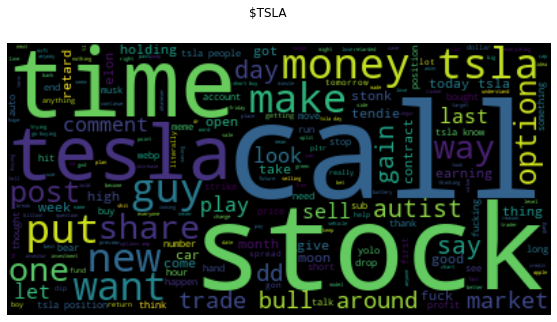

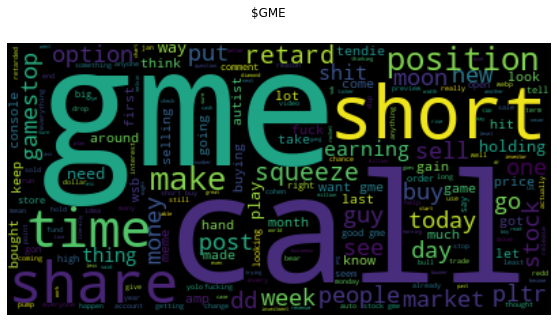

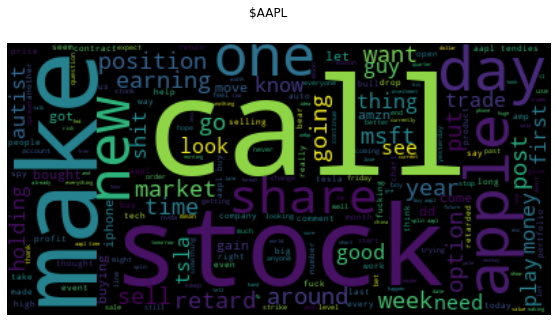

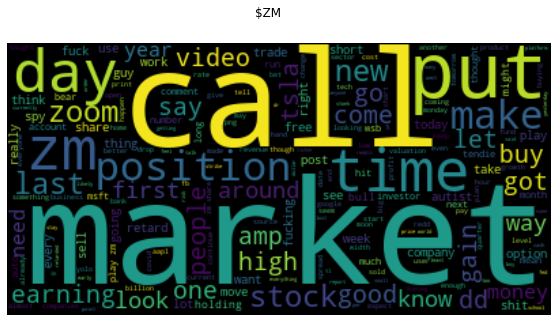

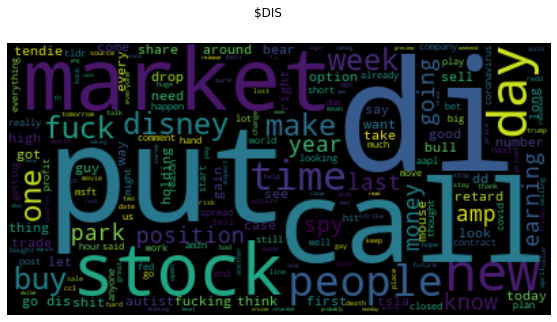

In [18]:
# Generate a word cloud image
for stock in stonks:
    wc = WordCloud().generate(' '.join(documents[stock]))
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 5))
    fig.suptitle(f'${stock.upper()}', fontsize='large')
    ax.imshow(wc, interpolation='bilinear')
    ax.axis('off')
    plt.show()

## Part 2: Sentiment analysis

### Preliminaries

In [19]:
hedonometer = pd.read_csv('Hedonometer.csv')
hedonometer.head()

,Rank,Word,Word in English,Happiness Score,Standard Deviation of Ratings
0,0,laughter,laughter,8.50,0.93
1,1,happiness,happiness,8.44,0.97
2,2,love,love,8.42,1.11
3,3,happy,happy,8.30,0.99
4,4,laughed,laughed,8.26,1.16


In [20]:
hed_dict = hedonometer.loc[:, ('Word', 'Happiness Score')].set_index('Word')['Happiness Score'].to_dict()

In [21]:
def doc2score(doc: list[str]) -> float:
    """Computes the happiness score of a document (list of tokens)."""
    count = Counter(doc)
    n_words = 0
    score = 0
    for term, freq in count.items():
        if term in hed_dict:
            n_words += freq
            score += hed_dict[term] * freq
    score /= n_words
    return score

In [22]:
daily_words = submissions.groupby('date').agg({'tokens': sum})['tokens']
daily_words.head()

date
2019-12-31    [us, amzn, clearly, given, ally, buying, obvio...
2020-01-01    [dildo, home, year, new, sitting, guys, ya, bu...
2020-01-02    [believe, year, read, say, range, baba, opinio...
2020-01-03    [strait, help, would, assuming, becky, fucked,...
2020-01-04    [due, new, wan, anything, european, others, cf...
Name: tokens, dtype: object

In [23]:
daily_happiness = pd.Series({date: doc2score(doc) for date, doc in zip(daily_words.index, daily_words.values)})
daily_happiness.head()

2019-12-31    5.725481
2020-01-01    5.634265
2020-01-02    5.578427
2020-01-03    5.475959
2020-01-04    5.558981
dtype: float64

### 1. 
Pick a day of your choice in 2020. We call it $d$. It is more interesting if you pick a day where you expect something relevant to occur (e.g. Christmas, New Year, Corona starting, the market crashes...).

In [ ]:
# Christmas eve :^) 
d = '2020-12-24'

### 2. 
Build two lists $l$ and $l_{ref}$ containing all tokens for submissions posted on r/wallstreebets on day $d$, and in the 7 days preceding day $d$, respectively. 

In [24]:
d = dt.datetime.strptime(d, '%Y-%m-%d').date()
dmin = d - dt.timedelta(days=7)
d, dmin = str(d), str(dmin)
d, dmin

('2020-12-24', '2020-12-17')

In [25]:
l = daily_words.loc[d]
lref = daily_words[(daily_words.index<d) & (daily_words.index>dmin)].values.sum()
len(l), len(lref)

(21134, 80256)

### 3. 
For each token $i$, compute the relative frequency in the two lists $l$ and $l_{ref}$. We call them $p(i,l)$ and $p(i,l_{ref})$, respectively. The relative frequency is computed as the number of times a token occurs over the total length of the document. Store the result in a dictionary.

In [27]:
def topx(d: dict[float], x=10) -> None:
    """Helper function to print top x items of a dictionary of floats."""
    print(sorted(d.items(), key=lambda y: y[1], reverse=True)[:x])

In [26]:
# Relative frequency
n_l = len(l)
n_lref = len(lref)
p = {token: freq / n_l for token, freq in Counter(l).items()}
pref = {token: freq / n_lref for token, freq in Counter(lref).items()}

topx(p)
topx(pref)

### 4. 
For each token $i$, compute the difference in relative frequency $\delta p(i) = p(i,l) - p(i,l_{ref})$. Store the values in a dictionary. Print the top 10 tokens (those with largest relative frequency). Do you notice anything interesting?

In [29]:
all_tokens = set(p.keys()).union(set(pref.keys()))

dp = {token: p.get(token, 0) - pref.get(token, 0) for token in all_tokens}

topx(dp)

### 5. 
Now, for each token, compute the happiness $h(i) = labMT(i) - 5$, using the labMT dictionary. Here, we subtract $5$, so that positive tokens will have a positive value and negative tokens will have a negative value. Then, compute the product $\delta \Phi = h(i)\cdot \delta p(i)$. Store the results in a dictionary. 

In [32]:
h = {token: hed_dict[token] - 5 for token in all_tokens if token in hed_dict}

dPhi = {token: h[token] * dp[token] for token in h}

### 6. 
Print the top 10 tokens, ordered by the absolute value of $|\delta \Phi|$. Explain in your own words the meaning of $\delta \Phi$. If that is unclear, have a look at [this page](https://shifterator.readthedocs.io/en/latest/cookbook/weighted_avg_shifts.html).

In [45]:
dPhi_abs = {token: abs(value) for token, value in dPhi.items()}

topx(dPhi_abs)

[('christmas', 0.003176069849878704), ('merry', 0.0024416146744348243), ('thanks', 0.0015414061017802558), ('money', 0.0013995672351361987), ('buying', 0.0012749817598919574), ('profit', 0.001250254508747932), ('real', 0.0012114215253122439), ('holidays', 0.001105530910908128), ('covid', 0.0010944953908446884), ('pretty', 0.0010732485798449595)]


### 8. 
Use the function ``shifterator.WeightedAvgShift`` to plot the WordShift, showing which words contributed the most to make your day of choice _d_ happier or more sad then days in the preceding 7 days. Comment on the figure. 

In [35]:
sentiment_shift = sh.WeightedAvgShift(
    type2freq_1=pref,
    type2freq_2=p,
    type2score_1=hed_dict,
    reference_value=5
)

C:\Users\runes\.conda\envs\comsosci\lib\site-packages\shifterator\plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


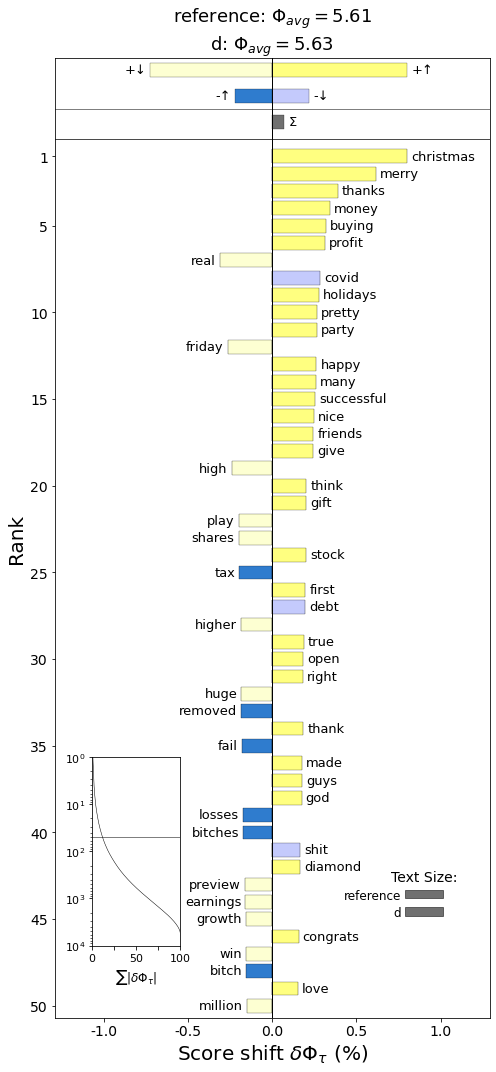

In [36]:
sentiment_shift.get_shift_graph(
    detailed=True,
    system_names=['reference', 'd']
)
plt.show()

### 9. 
How do words that you printed in step 6 relate to those shown by the WordShift? 

## Part 3: Communities for the Zachary Karate Club Network

_Exercise: Zachary's karate club_: In this exercise, we will work on Zarachy's karate club graph (refer to the Introduction of Chapter 9). The dataset is available in NetworkX, by calling the function [karate_club_graph](https://networkx.org/documentation/stable/auto_examples/graph/plot_karate_club.html).

> 1. Visualize the graph using [netwulf](https://netwulf.readthedocs.io/en/latest/). Set the color of each node based on the club split (the information is stored as a node attribute). My version of the visualization is below.
>
> 2. Write a function to compute the __modularity__ of a graph partitioning (use **equation 9.12** in the book). The function should take a networkX Graph and a partitioning as inputs and return the modularity.
> 3. Explain in your own words the concept of _modularity_. 
> 4. Compute the modularity of the Karate club split partitioning using the function you just wrote. Note: the Karate club split partitioning is avilable as a [node attribute](https://networkx.org/documentation/networkx-1.10/reference/generated/networkx.classes.function.get_node_attributes.html), called _"club"_.
> 5. We will now perform a small randomization experiment to assess if the modularity you just computed is statitically different from $0$. To do so, we will implement a [configuration model](https://en.wikipedia.org/wiki/Configuration_model). In short, we will create a new network, such that each node has the same degree as in the original network, but different connections. Here is how the algorithm works.
>       * __a.__ Create an identical copy of your original network. 
>       * __b.__ Consider the list of network edges. Create two lists: the list of source nodes and target nodes. (e.g. edges = [(1,2),(3,4)], sources = [1,3], targets = [2,4])
>       * __c.__ Concatenate the list of source nodes and target nodes into a unique list (e.g. [1,3,2,4]). This is the list of _stubs_ (see the [Wikipedia page](https://en.wikipedia.org/wiki/Configuration_model) for the definition of stub).
>       * __d.__ Shuffle the list of stubs. Build a set of edges (tuples), by connecting each element in the list of shuffled stubs with the following element. (e.g. [4,1,2,3] --> [(4,1),(2,3)])
>       * __e.__ Remove all the original network edges from your network. Add all the new _shuffled_ edges you created in step __d.__
> 6. Is the degree of the nodes in your original and the configuration model network the same? Why? __Note 1:__ With this algorithm you may obtain some self-loops. Note that [a self-loop should add two to the degree](https://en.wikipedia.org/wiki/Loop_(graph_theory%29#:~:text=For%20an%20undirected%20graph%2C%20the,adds%20two%20to%20the%20degree.&text=In%20other%20words%2C%20a%20vertex,not%20one%2C%20to%20the%20degree.). __Note 2:__ With this algorithm, you could also obtain repeated edges between the same two nodes. Only NetworkX [MultiGraph](https://networkx.org/documentation/stable/reference/classes/multigraph.html) allow for repeated edges, while regular [Graph](https://networkx.org/documentation/stable/reference/classes/graph.html?highlight=graph%20undirected#networkx.Graph) do not, meaning you will not be able to account for multi-edges when you have a regular Graph. (_Optional_: if you want to implement a configuration model without self-loops and multi-edges, you can try out the [double_edge_swap](https://networkx.org/documentation/stable//reference/algorithms/generated/networkx.algorithms.swap.double_edge_swap.html) algorithm)
> 7. Create $1000$ randomized version of the Karate Club network using the algorithm you wrote in step 5. For each of them, compute the modularity of the "club" split and store it in a list.
> 8. Compute the average and standard deviation of the modularity for the configuration model.
> 9. Plot the distribution of the configuration model modularity. Plot the actual modularity of the club split as a vertical line (use [axvline](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.axvline.html)). 
> 10. Comment on the figure. Is the club split a good partitioning? Why do you think I asked you to compare with the configuration model? What is the reason why we preserved the nodes degree?
> 11.  Use [the Python Louvain-algorithm implementation](https://anaconda.org/auto/python-louvain) to find communities in this graph. Report the value of modularity found by the algorithm. Is it higher or lower than what you found above for the club split? What does this comparison reveal?
> 12.  Compare the communities found by the Louvain algorithm with the club split partitioning by creating a matrix **_D_** with dimension (2 times _A_), where _A_ is the number of communities found by Louvain. We set entry _D_(_i_,_j_) to be the number of nodes that community _i_ has in common with group split _j_. The matrix **_D_** is what we call a [**confusion matrix**](https://en.wikipedia.org/wiki/Confusion_matrix). Use the confusion matrix to explain how well the communities you've detected correspond to the club split partitioning.

_Exercise: Community detection on the GME network._
> * Consider the GME network you built in [Week 4](https://github.com/lalessan/comsocsci2022/blob/main/lectures/Week4.ipynb), part 2.
> * Use [the Python Louvain-algorithm implementation](https://anaconda.org/auto/python-louvain) to find communities. How many communities do you find? What are their sizes? Report the value of modularity found by the algorithm. Is the modularity significantly different than 0? 
> * Visualize the network, using netwulf (see Week 4). This time assign each node a different color based on their _community_. Describe the structure you observe.